# Purpose: 
Development of temporal analysis on office predicted products

In [7]:
import pandas as pd 
import os 
import json 
import time 
import pyarrow as pa
import pyarrow.parquet as pq
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

0it [00:00, ?it/s]

In [8]:
path = 'office_product_analysis_file_rr.parquet'

In [9]:
# read the office file for time analysis
major_df_pq =  pq.read_table(path)
# Convert the PyArrow table to a Pandas DataFrame
major_df = major_df_pq.to_pandas()

In [10]:
major_df.shape

(1433991, 15)

In [11]:
major_df.columns

Index(['review_id', 'review_date', 'rating', 'review_body', 'date_converted',
       'year', 'language', 'zero_stars', 'rating_management_explicit',
       'wrong_buying', 'disagreement_with_ratings', 'read_reviews',
       'product_id', 'min_date', 'product_year'],
      dtype='object')

In [12]:
# create a column for before 2020 to after 2020: 
def one_hot_encode_2020_policy(year): 
    if year>= 2020:
        return 1
    else: 
        return 0 

In [13]:
# one hot encoding for pre and post 2020, assign 1 for everything after 2020 and 0 for everything before 2020
major_df['pre_post_2020']= major_df['year'].progress_apply(lambda x: one_hot_encode_2020_policy(x))

  0%|          | 0/1433991 [00:00<?, ?it/s]

In [14]:
def create_relevant_label_table(master_df, col_name): 
    relevant_df = master_df[['year', 'pre_post_2020', col_name]]
    return relevant_df

def grouped_counts(df, label): 
    # Group by Year and Label and count occurrences
    grouped_counts = df.groupby(['year', label]).size().reset_index(name='Counts')
    # Pivot the DataFrame
    pivoted_counts = grouped_counts.pivot(index='year', columns=label, values='Counts')
    values= {1:0}
    pivoted_counts_1 = pivoted_counts.fillna(value = values)
    # Calculate percentages
    pivoted_percentages = pivoted_counts.apply(lambda x: (x / x.sum()) * 100, axis=1)
    pivoted_percentages = pivoted_percentages.fillna(value = values)
    # Assuming you have a DataFrame called 'pivoted_percentages' with column names as integers 0 and 1
    pivoted_percentages = pivoted_percentages.rename(columns={0: 'label_0', 1: 'label_1'})
    pivoted_percentages = pivoted_percentages.reset_index()

    return pivoted_percentages

def plot_time_series_label_1(df, label, png_name=None): 
    column_name = 'label_1' # Replace with the actual column name you want to plot

    # Plot the specified column
    plt.plot(df['year'], df[column_name])

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel(f'Percentage of {label}')
    plt.title(f'Percentage of {label} over Time')
    time.sleep(5)

#     Save the plot
    plt.savefig(f'{png_name}.png')
#     Show the plot
    plt.show()

def label_absolute_cnts(df, label): 
    grouped_counts = df.groupby(['year', label]).size().reset_index(name='Counts')
    # Pivot the DataFrame
    pivoted_counts = grouped_counts.pivot(index='year', columns=label, values='Counts')
    values= {1:0}
    pivoted_counts_1 = pivoted_counts.fillna(value = values)
    # Assuming you have a DataFrame called 'pivoted_percentages' with column names as integers 0 and 1
    pivoted_counts_1 = pivoted_counts_1.rename(columns={0: 'label_0', 1: 'label_1'})
    return pivoted_counts_1


def label_comparison_plt(df, label):
    # Create a figure and axis objects
    fig, ax1 = plt.subplots(figsize=(8, 6))
    # Plot the first label's counts on the primary y-axis
    ax1.plot(df.index, df['label_0'], color='red', marker='o')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Not Tagged' + ' Counts', color='red')
    # Create a twin y-axis
    ax2 = ax1.twinx()
    # Plot the second label's counts on the secondary y-axis
    ax2.plot(df.index, df['label_1'], color='blue', marker='o')
    ax2.set_ylabel(f'{label}' + ' Counts', color='blue')
    # Add a legend
    ax1.legend([0, 1])
    plt.title(f'Not Tagged vs {label} Tagged')
     # Wait for the plot to render
    time.sleep(5)

    # Save the plot
    plt.savefig(f'{label}VSnot_tagged.png')
    # Show the plot
    plt.show()

def product_release_df(df, label): 
    # filter for zero stars label ==1 only: 
    prod_df = df[df[label]==1]
    # # create prod concat label ==1 column
    # test_df['prod_label_1']= str(test_df['zero_stars'])+'_'+str(test_df['product_year']) do not need
    grouped_counts = prod_df.groupby(['year', 'product_year']).size().reset_index(name='Counts')
    # # Pivot the DataFrame
    pivoted_counts = grouped_counts.pivot(index='year', columns='product_year', values='Counts')
    # values= {1:0}
    pivoted_counts_1 = pivoted_counts.fillna(0)
    # # Calculate percentages
    pivoted_percentages = pivoted_counts.apply(lambda x: (x / x.sum()) * 100, axis=1)
    return pivoted_percentages

def plot_product_year_label(df, label, png_name=None):
    # Create a figure and axis objects
    fig, ax = plt.subplots()
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Plot the line for the current column
        ax.plot(df.index, df[column], marker='o', label=column)
    # Set the x-axis label
    ax.set_xlabel('Year')
    # Set the y-axis label
    ax.set_ylabel('Percentage of Reviews For Product Release Year')
    # Add a title
    ax.set_title(f'Time Effect Since Product Release for {label}')
    # Add a legend
    ax.legend()
#      Wait for the plot to render
    time.sleep(5)

#     Save the plot
    plt.savefig(f'{png_name}.png')
#     Show the plot
    plt.show()
   

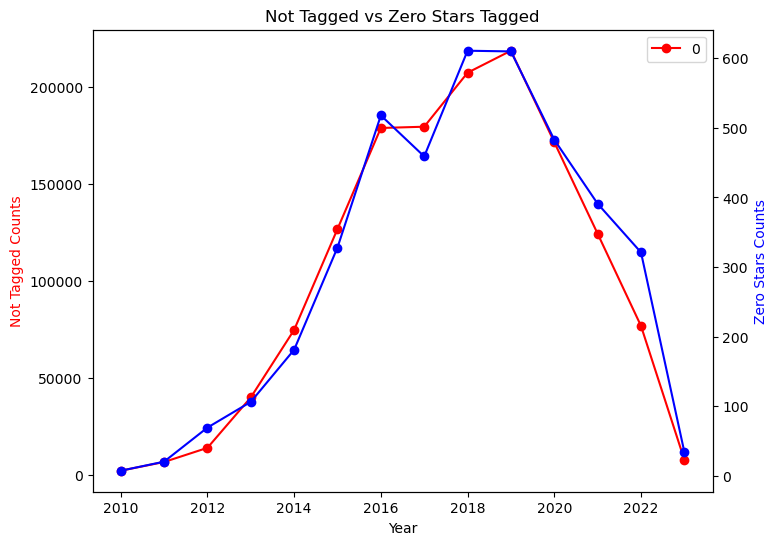

In [17]:
zero_star_df = create_relevant_label_table(major_df, 'zero_stars')
zero_star_abs_cnt = label_absolute_cnts(zero_star_df, 'zero_stars')
label_comparison_plt(zero_star_abs_cnt, "Zero Stars")

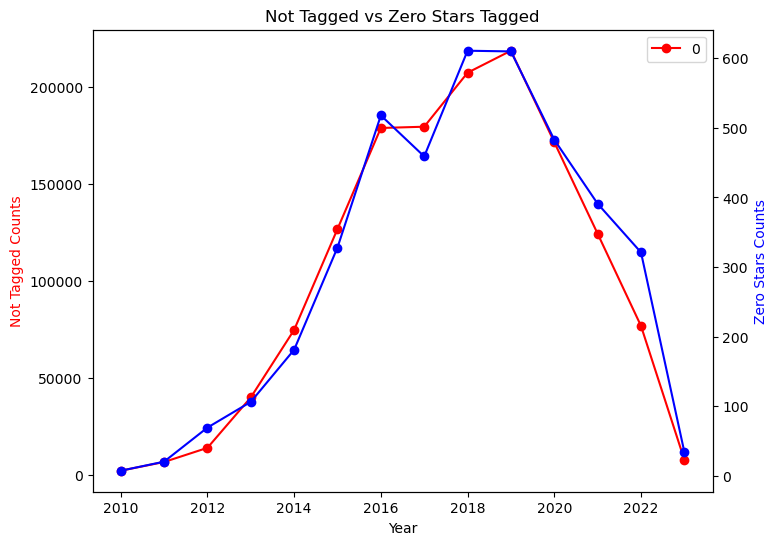

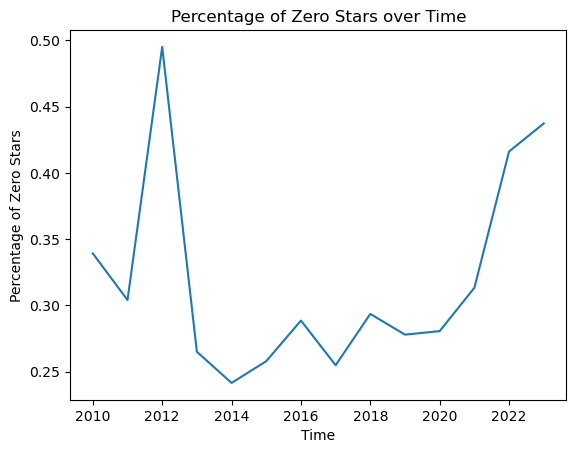

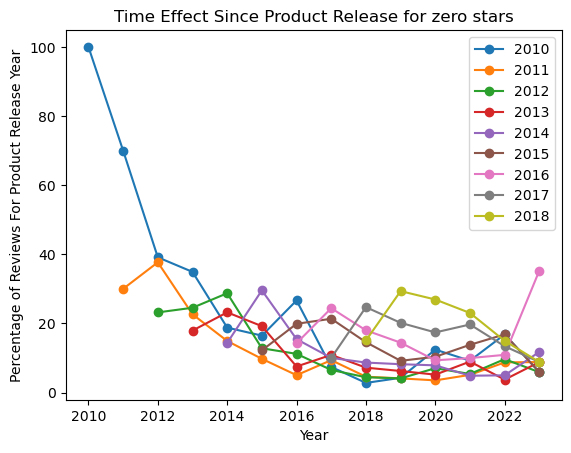

In [15]:
zero_star_df = create_relevant_label_table(major_df, 'zero_stars')
zero_star_abs_cnt = label_absolute_cnts(zero_star_df, 'zero_stars')
label_comparison_plt(zero_star_abs_cnt,"Zero Stars")
zero_pivot_df = grouped_counts(zero_star_df, 'zero_stars')
plot_time_series_label_1(zero_pivot_df,"Zero Stars", 'zero_stars_time')
zero_prod_df= product_release_df(major_df, 'zero_stars')
plot_product_year_label(zero_prod_df, 'zero stars')

In [45]:
zero_star_abs_cnt

zero_stars,label_0,label_1
year,,
2010,2057,7
2011,6559,20
2012,13871,69
2013,39898,106
2014,74779,181
2015,126865,328
2016,179019,518
2017,179671,459
2018,207550,611


In [46]:
zero_pivot_df

zero_stars,year,label_0,label_1
0,2010,99.660853,0.339147
1,2011,99.696002,0.303998
2,2012,99.505022,0.494978
3,2013,99.735026,0.264974
4,2014,99.758538,0.241462
5,2015,99.742124,0.257876
6,2016,99.711480,0.288520
7,2017,99.745184,0.254816
8,2018,99.706477,0.293523
9,2019,99.722118,0.277882


In [47]:
zero_prod_df

product_year,2010,2011,2012,2013,2014,2015,2016,2017,2018
year,,,,,,,,,
2010,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,70.000000,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,39.130435,37.681159,23.188406,NaN,NaN,NaN,NaN,NaN,NaN
2013,34.905660,22.641509,24.528302,17.924528,NaN,NaN,NaN,NaN,NaN
2014,18.784530,14.917127,28.729282,23.204420,14.364641,NaN,NaN,NaN,NaN
2015,16.463415,9.756098,12.804878,19.207317,29.573171,12.195122,NaN,NaN,NaN
2016,26.640927,5.019305,11.196911,7.528958,15.444015,19.884170,14.285714,NaN,NaN
2017,7.407407,9.368192,6.535948,10.893246,10.021786,21.350763,24.400871,10.021786,NaN
2018,2.782324,4.582651,4.418985,7.201309,8.674304,14.566285,18.003273,24.713584,15.057283


# RATING MANAGEMENT EXPLICIT

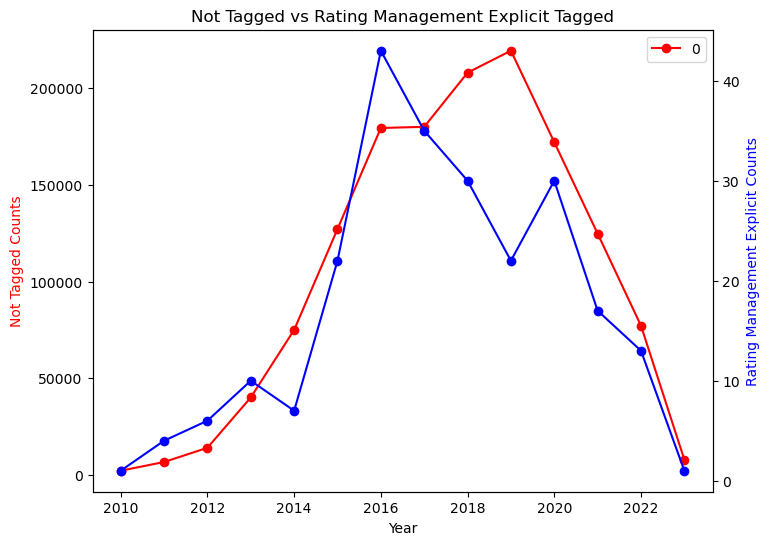

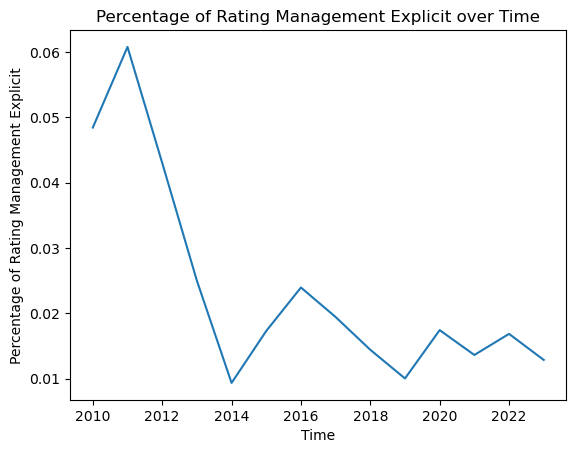

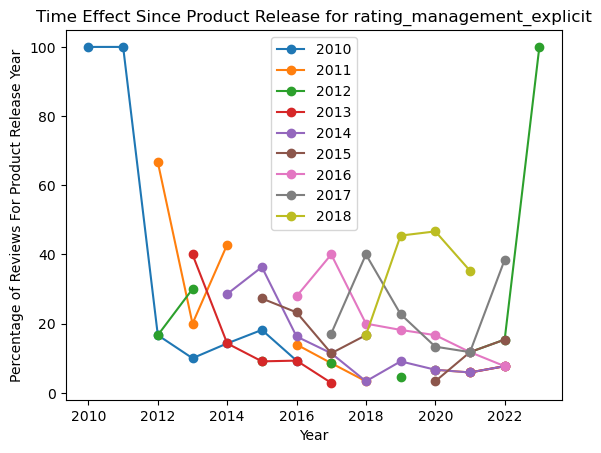

In [16]:
rating_management_explicit = create_relevant_label_table(major_df, 'rating_management_explicit')
rating_management_explicit_abs_cnt = label_absolute_cnts(rating_management_explicit, 'rating_management_explicit')
label_comparison_plt(rating_management_explicit_abs_cnt, "Rating Management Explicit")
rating_management_explicit_pivot_df = grouped_counts(rating_management_explicit, 'rating_management_explicit')
plot_time_series_label_1(rating_management_explicit_pivot_df,"Rating Management Explicit","Rating Management Explicit")
rating_management_prod_df= product_release_df(major_df, 'rating_management_explicit')
plot_product_year_label(rating_management_prod_df, "rating_management_explicit", "Rating Management Explicit")

In [21]:
rating_management_explicit_pivot_df

rating_management_explicit,year,label_0,label_1
0,2010,99.951550,0.048450
1,2011,99.939200,0.060800
2,2012,99.956958,0.043042
3,2013,99.975002,0.024998
4,2014,99.990662,0.009338
5,2015,99.982703,0.017297
6,2016,99.976050,0.023950
7,2017,99.980570,0.019430
8,2018,99.985588,0.014412
9,2019,99.989978,0.010022


# DISAGREEMENT WITH RATINGS

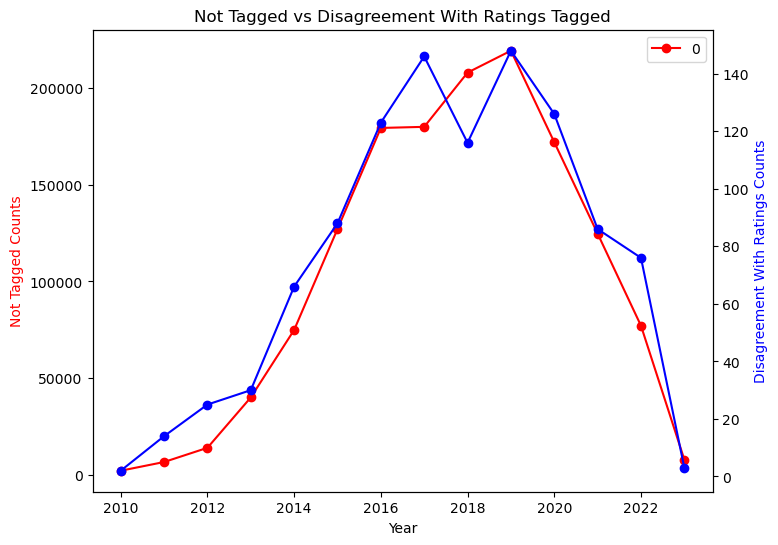

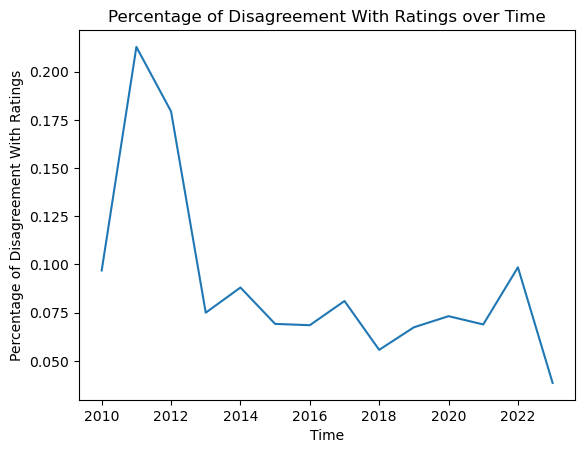

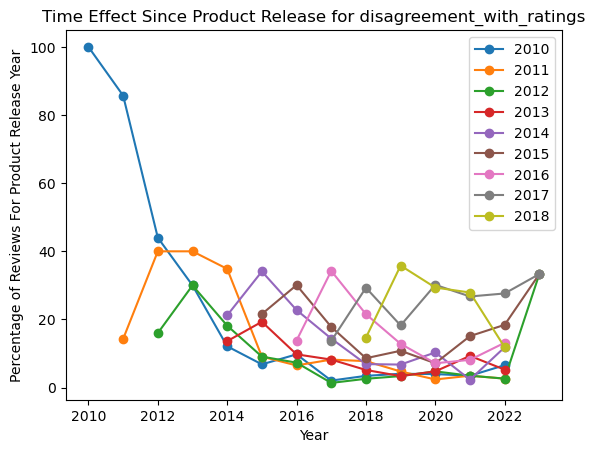

In [17]:
disagreement_with_ratings = create_relevant_label_table(major_df, 'disagreement_with_ratings')
disagreement_with_ratings_abs_cnt = label_absolute_cnts(disagreement_with_ratings, 'disagreement_with_ratings')
label_comparison_plt(disagreement_with_ratings_abs_cnt, "Disagreement With Ratings")
disagreement_with_ratings_pivot_df = grouped_counts(disagreement_with_ratings, 'disagreement_with_ratings')
plot_time_series_label_1(disagreement_with_ratings_pivot_df,"Disagreement With Ratings","Disagreement With Ratings")
disagreement_with_ratings_prod_df= product_release_df(major_df, 'disagreement_with_ratings')
plot_product_year_label(disagreement_with_ratings_prod_df, 'disagreement_with_ratings')

In [23]:
disagreement_with_ratings_pivot_df

disagreement_with_ratings,year,label_0,label_1
0,2010,99.903101,0.096899
1,2011,99.787202,0.212798
2,2012,99.820660,0.179340
3,2013,99.925007,0.074993
4,2014,99.911953,0.088047
5,2015,99.930814,0.069186
6,2016,99.931490,0.068510
7,2017,99.918947,0.081053
8,2018,99.944274,0.055726
9,2019,99.932580,0.067420


# wrong_buying

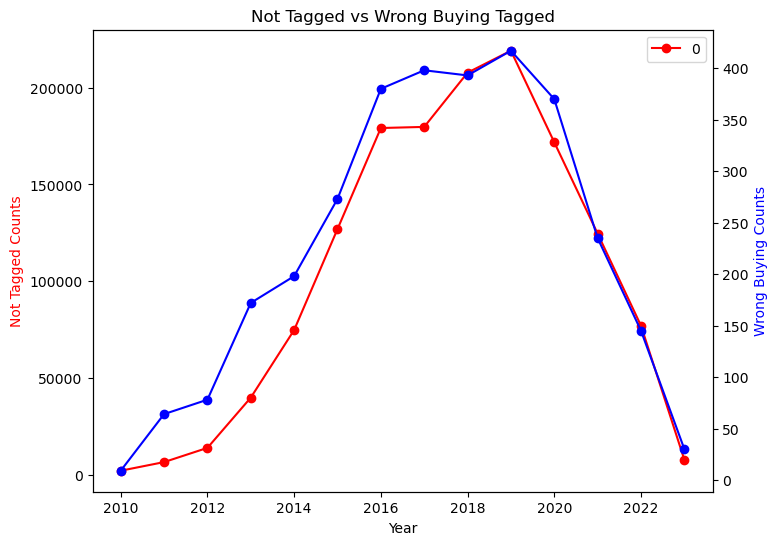

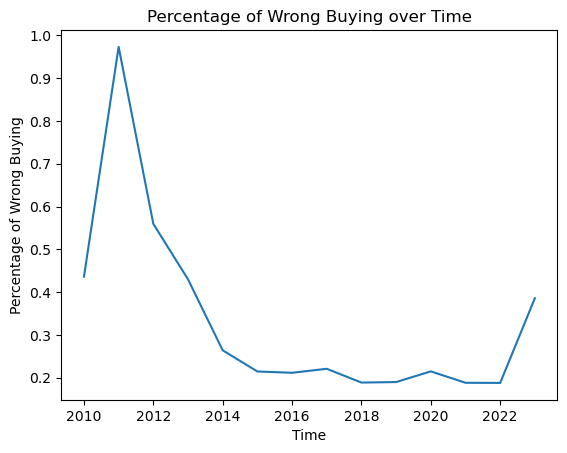

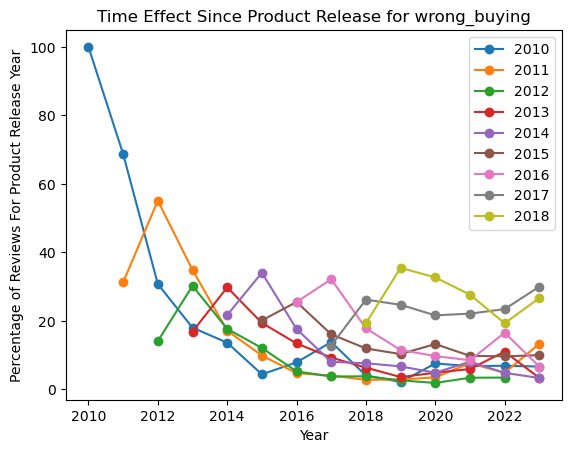

In [18]:
wrong_buying = create_relevant_label_table(major_df, 'wrong_buying')
wrong_buying_abs_cnt = label_absolute_cnts(wrong_buying, 'wrong_buying')
label_comparison_plt(wrong_buying_abs_cnt, "Wrong Buying")
wrong_buying_pivot_df = grouped_counts(wrong_buying, 'wrong_buying')
plot_time_series_label_1(wrong_buying_pivot_df, "Wrong Buying","Wrong Buying" )
wrong_buying_prod_df= product_release_df(major_df, 'wrong_buying')
plot_product_year_label(wrong_buying_prod_df, 'wrong_buying')

In [58]:
wrong_buying_pivot_df

wrong_buying,year,label_0,label_1
0,2010,99.563953,0.436047
1,2011,99.027208,0.972792
2,2012,99.440459,0.559541
3,2013,99.570043,0.429957
4,2014,99.735859,0.264141
5,2015,99.785366,0.214634
6,2016,99.788344,0.211656
7,2017,99.779048,0.220952
8,2018,99.811204,0.188796
9,2019,99.810038,0.189962


In [59]:
wrong_buying_prod_df

product_year,2010,2011,2012,2013,2014,2015,2016,2017,2018
year,,,,,,,,,
2010,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,68.750000,31.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,30.769231,55.128205,14.102564,NaN,NaN,NaN,NaN,NaN,NaN
2013,18.023256,34.883721,30.232558,16.860465,NaN,NaN,NaN,NaN,NaN
2014,13.636364,17.171717,17.676768,29.797980,21.717172,NaN,NaN,NaN,NaN
2015,4.395604,9.890110,12.087912,19.413919,34.065934,20.146520,NaN,NaN,NaN
2016,7.894737,4.736842,5.263158,13.421053,17.631579,25.526316,25.526316,NaN,NaN
2017,13.819095,4.020101,3.768844,9.296482,8.040201,16.080402,32.160804,12.814070,NaN
2018,4.071247,2.798982,3.816794,6.361323,7.633588,11.959288,17.811705,26.208651,19.338422


# Read Reviews

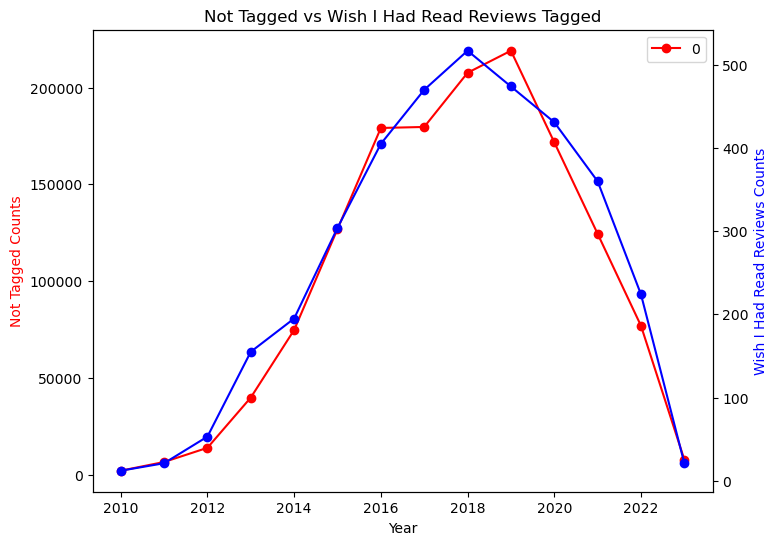

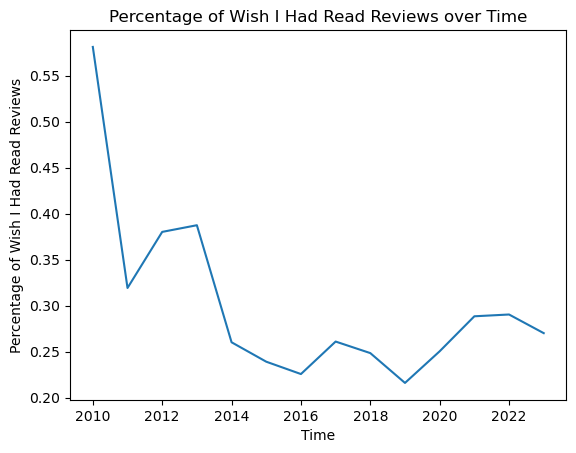

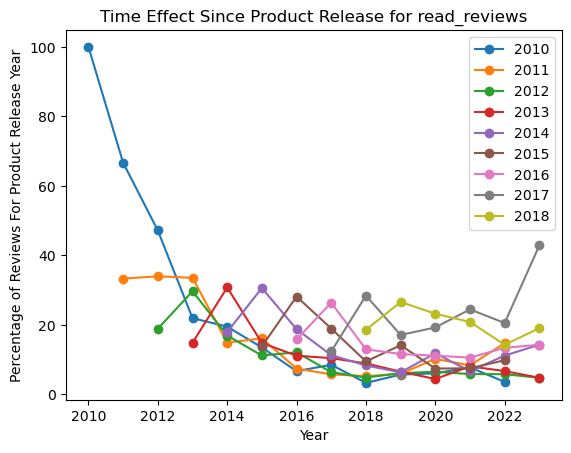

In [19]:
read_reviews = create_relevant_label_table(major_df, 'read_reviews')
read_reviews_abs_cnt = label_absolute_cnts(read_reviews, 'read_reviews')
label_comparison_plt(read_reviews_abs_cnt, "Wish I Had Read Reviews")
read_reviews_pivot_df = grouped_counts(read_reviews, 'read_reviews')
plot_time_series_label_1(read_reviews_pivot_df, "Wish I Had Read Reviews","Wish I Had Read Reviews" )
read_reviews_prod_df= product_release_df(major_df, 'read_reviews')
plot_product_year_label(read_reviews_prod_df, 'read_reviews')

In [8]:
major_df

,review_id,review_date,rating,review_body,date_converted,year,language,zero_stars,rating_management_explicit,wrong_buying,disagreement_with_ratings,product_id,min_date,product_year,pre_post_2020
0,R1S2PIZEIYGBV7,"Reviewed in the United States on October 8, 2019",5.0 out of 5 stars,Gorgeous Leather Bound Diary...Old World Quali...,2019-10-08 00:00:00,2019,en,0,0,0,0,B00OR7MNDY,2014-12-29 00:00:00,2014,0
1,R1EMNPBW34DL6Q,"Reviewed in the United States on September 22,...",4.0 out of 5 stars,"Awesome little notebook,just wish it came with...",2018-09-22 00:00:00,2018,en,0,0,0,0,B00OR7MNDY,2014-12-29 00:00:00,2014,0
2,R1OORI57AQ0SZD,"Reviewed in the United States on March 21, 2018",5.0 out of 5 stars,Very great quality. It has such a charm to it ...,2018-03-21 00:00:00,2018,en,0,0,0,0,B00OR7MNDY,2014-12-29 00:00:00,2014,0
3,R1GPO495D2A8ZN,"Reviewed in the United States on March 7, 2018",5.0 out of 5 stars,amazing quality and great price,2018-03-07 00:00:00,2018,en,0,0,0,0,B00OR7MNDY,2014-12-29 00:00:00,2014,0
4,R3Q9P0PVL448ID,"Reviewed in the United States on February 19, ...",5.0 out of 5 stars,My husband really likes this journel.,2018-02-19 00:00:00,2018,en,0,0,0,0,B00OR7MNDY,2014-12-29 00:00:00,2014,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1774781,R24KK07X8FEINH,"Reviewed in the United States on March 15, 2018",5.0 out of 5 stars,Looks a little different than the stock toner ...,2018-03-15 00:00:00,2018,en,0,0,0,0,B00JS8FF4Q,2017-04-21 00:00:00,2017,0
1774782,R3AMHZ6CZAWBPA,"Reviewed in the United States on March 7, 2018",5.0 out of 5 stars,Simple to install and works great in my Samsun...,2018-03-07 00:00:00,2018,en,0,0,0,0,B00JS8FF4Q,2017-04-21 00:00:00,2017,0
1774783,R1OQETO0Z4LRV6,"Reviewed in the United States on February 26, ...",5.0 out of 5 stars,Works good,2018-02-26 00:00:00,2018,en,0,0,0,0,B00JS8FF4Q,2017-04-21 00:00:00,2017,0
1774784,R3RJO6APVB9GO4,"Reviewed in the United States on June 7, 2017",5.0 out of 5 stars,Works perfectly with my Samsung printer.,2017-06-07 00:00:00,2017,en,0,0,0,0,B00JS8FF4Q,2017-04-21 00:00:00,2017,0


In [14]:
# test_df['prod_label_1']= str(test_df['zero_stars'])+'_'+str(test_df['product_year']) do not need
grouped_counts = major_df.groupby(['year', 'product_year']).size().reset_index(name='Counts')
# # Pivot the DataFrame
pivoted_counts = grouped_counts.pivot(index='year', columns='product_year', values='Counts')
# values= {1:0}
pivoted_counts_1 = pivoted_counts.fillna(0)
# # Calculate percentages
pivoted_percentages = pivoted_counts.apply(lambda x: (x / x.sum()) * 100, axis=1)

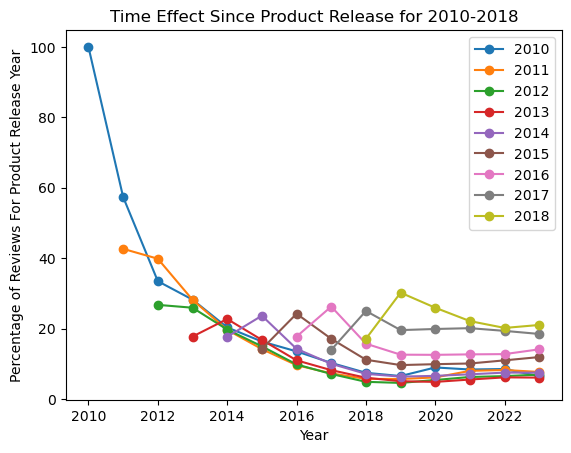

In [15]:
plot_product_year_label(pivoted_percentages, '2010-2018', 'overall_prod_release')

In [21]:
major_df['sentence_length']= major_df['review_body'].apply(lambda x: len(x.split()))

In [28]:
def create_sentence_list(df, label): 
    df_1 = df[df[label]==1]
    return df_1['sentence_length'].tolist()

In [31]:
zero_stars= create_sentence_list(major_df, 'zero_stars')
disagreement= create_sentence_list(major_df, 'disagreement_with_ratings')
rating_management_explicit = create_sentence_list(major_df, 'rating_management_explicit')
wrong_buying = create_sentence_list(major_df, 'wrong_buying')

In [39]:
len(wrong_buying)

3162

In [44]:
# Calculate the average
average = sum(wrong_buying) / len(wrong_buying)

print("Average:", average)

Average: 89.70746363061353


In [45]:
# Calculate the average
average = sum(zero_stars) / len(zero_stars)

print("Average:", average)

Average: 46.584823586273565


In [46]:
# Calculate the average
average = sum(rating_management_explicit) / len(rating_management_explicit)

print("Average:", average)

Average: 95.04979253112033


In [ ]:
# Calculate the average
average = sum(disagreement_with_rati) / len(rating_management_explicit)

print("Average:", average)